# SAMPLE RUNTHROUGH

## PREPARE DATA

In [4]:
with open('data/names.txt') as f:
    names = f.readlines()
names = [name.strip() for name in names]

itos = {}
stoi = {}

itos[0]='.'
stoi['.']=0

letters=sorted(list(set("".join(names))))

for idx,letter in enumerate(letters):
    stoi[letter]=idx+1
    itos[idx+1]=letter

print(stoi)
print(itos)



{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [5]:
# Don't change these parameters, as they are used in the explanation in the SAMPLE RUNTHROUGH part
SAMPLE_CONTEXT_SIZE = 3
SAMPLE_LETTER_EMBEDDING_SIZE=2
SAMPLE_TRAINING_DATA_SIZE=5
SAMPLE_HIDDEN_LAYER_NEURONS=100

In [6]:
import torch

def generate_training_data(names,block_size=3,print_out=False):
    X = []
    Y = []
    for name in names:
        name = name + "."
        context = block_size * [0]
        if print_out:
            print(name)
        for ch in name:
            context_str = "".join([itos[idx] for idx in context])
            predict_str = ch
            if print_out:
                print(f"{context_str}-->{predict_str}")
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:]+[stoi[ch]]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X, Y

X,Y = generate_training_data(names[:SAMPLE_TRAINING_DATA_SIZE],SAMPLE_CONTEXT_SIZE)



We have 32 examples with 3 context letters each

In [7]:
X.shape

torch.Size([32, 3])

## START BUILDING THE NEURAL NETWORK

### ARCHITECTURE OF NEURAL NETWORK
![](./data/img/makemore_l2.png)

### CREATE LETTER EMBEDDINGS

Represent each letter in alpabeth with 2 dimensional embedding vector. Initialize the embedding vectors randomly.

In [8]:
C = torch.randn(27,SAMPLE_LETTER_EMBEDDING_SIZE).float()
C.shape

torch.Size([27, 2])

Create embeddings "emb" for all the training samples for each context word.       
The result: A tensor (multidimensional matrix) with dimensions | Train size * Context Size * Letter embedding Size |

Where 

- Train size : How many training examples our data has 
- Context size : How many previous letters we use to predict the next letter
- Letter embedding size : How many dimensions we use to model 1 letter

In [9]:
emb = C[X] 
# C is 27 * 2
# X is 32 * 3 where each value is a letter index from 0-27 
# We basically choose a 2 dimensional vector for each letter index in X
emb.shape

torch.Size([32, 3, 2])

Below is the first training sample context letters as 2 dimensional vectors

In [10]:
emb[0]

tensor([[-0.3882,  0.7680],
        [-0.3882,  0.7680],
        [-0.3882,  0.7680]])

### CREATE NEURON WEIGHTS

Each neuron has weight for all context letter all dimensions


In [11]:
W1 = torch.randn([SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE,SAMPLE_HIDDEN_LAYER_NEURONS])
W1.shape

torch.Size([6, 100])

Let's create bias parameter as well

In [12]:
b1 = torch.randn(SAMPLE_HIDDEN_LAYER_NEURONS) 
b1.shape

torch.Size([100])

### SHAPE TRAINING DATA SO WE COULD MATRIX MULTIPLY IT WITH NEURONS

This means the training data rows need to have have as many columns as neurons take inputs.

**NOT WELL PERFORMING SAMPLE**

The unbind operation seems to take a particular dimension and remove it in a way that instead of that dimension you will have that dimension represented in multiple lists for each dimension. It allows us to do easy concatenation.

In [13]:
training_data = torch.cat(torch.unbind(emb,1),1) 

In [14]:
training_data.shape

torch.Size([32, 6])

**BETTER PERFORMING SAMPLE** 

View is a much faster operation compared to cat and bind because it does not need to use extra memory. It is also able to sort of unstack the tensor dimensions

In [15]:
(torch.eq(training_data, emb.view(-1,6)).all())

tensor(True)

emb.view(-1,6)

### FIRST PART OF FORWARD PROPAGATION

Here we flow the data through first 100 neurons. 

For each sample we now get 100 values. 


In [16]:
training_data = emb.view(-1,SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE) 
h = training_data @ W1 + b1
h.shape

torch.Size([32, 100])

### COMPLETE ONE TIME FORWARD PASS

We create second layer with softmax function. There will be 27 neurons,
each neuron output will be a probability for particular letter

In [17]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
logits = h.tanh() @ W2 + b2 
counts = logits.exp()
probs = counts/counts.sum(1,keepdim=True)


Check that for each training sample the probabilities will equal = 1

In [53]:
probs.sum(1,keepdim=True)[:10]

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

For each X get the probability for the right prediction. If it is low, the loglikelihood will return high loss

In [19]:
loss  = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [20]:
loss

tensor(14.3378)

## QUESTIONS


### QUESTION 1

- Are dimension mapping for each particular letter parameters in this neural network? 


### QUESTION 2

- If our dataset has 100 training examples. Each letter is mapped to 2 dimensions. We will have 100 neurons in middle layer and 27 neurons in the output layer. How many times for we update gradient for 1 character 1 dimension ?

## ANSWERS 


### ANSWER 1

- Yes, these are All dimensions for the 27 letters . These we will update in each training run to reduce loss. These parameters affect the multiplication with each neuron in the first hidden layer. 

### ANSWER 2 

Letter Dimension for one of the 27 layers is an instance shared among multiple training sample pairs. The cost function is calculated as comparison between all the training sample pairs. So if if specific word occurs in a training sample pair, then it's dimensions will also occur in the training sample pair which means it there is going to be a gradient update. 
In addition, the letter dimension will be input to 100 neurons. So for each neuron there willl be also gradient update.    
- In total, anwswer is going to be TRAINING_SET_OCCURENCES * OUTPUT_NEURONS_FOR_LETTER_EMBEDDINGS. More info on my [YT explanation](https://www.youtube.com/watch?v=KUw20-24YNE&ab_channel=AndresNamm)

# MORE RESPECTABLE VERSION OF NEURAL NETWORK + TRAINING

Lets define some default hyperparameters

In [21]:
EMBEDDING_DIMENSION = 2
CONTEXT_SIZE = 3
TRAINING_SIZE = -1 # -1 means all data
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 30

Let us now generate new training data

In [22]:
X,Y = generate_training_data(names[:TRAINING_SIZE], block_size=CONTEXT_SIZE,print_out=False)

print(f"X shape {X.shape}")
print(f"Y shape {Y.shape}")

X shape torch.Size([228140, 3])
Y shape torch.Size([228140])


Initialize parameters

In [23]:

def initialize_global_weights():
    global g, C, W1, B1, W2, B2, params
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(27,EMBEDDING_DIMENSION,generator=g) 
    W1 = torch.randn(EMBEDDING_DIMENSION*CONTEXT_SIZE,HIDDEN_LAYER_SIZE,generator=g)
    B1 = torch.randn(HIDDEN_LAYER_SIZE,generator=g) # Add to every neuron bias
    W2 = torch.randn(HIDDEN_LAYER_SIZE,27,generator=g)
    B2 = torch.randn(27) # Add to every neuron bias

    params = [C,W1,B1,W2,B2]
    param_count = sum([p.nelement()  for p in params])
    print(f"Total parameters currently in NN {param_count}")

    for p in params:
        p.requires_grad=True

initialize_global_weights()



Total parameters currently in NN 3481


## TRAINING WITH FULL DATA

In [24]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation
    h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    # manual method
    
    # counts = logits.exp()
    # probs = counts/counts.sum(1,keepdim=True)
    # loss += -probs[torch.arange(len(X)),Y].log().mean()
    loss = F.cross_entropy(logits, Y)

    print(f"Total loss currently is {loss}")
    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1


    if i > 3:
        print("This is too slow, let's implement the minibatch approach")
        break


Total loss currently is 19.08670425415039
Total loss currently is 16.60564613342285
Total loss currently is 15.364110946655273
Total loss currently is 14.367096900939941
Total loss currently is 13.54630184173584
This is too slow, let's implement the minibatch approach


## TRAINING WITH MINIBATCHES

In [34]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 10 == 0:
        print(f"Iteration {i}: Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1



Iteration 0: Total loss currently is 29.884632110595703
Iteration 10: Total loss currently is 19.906150817871094
Iteration 20: Total loss currently is 11.033354759216309
Iteration 30: Total loss currently is 8.874484062194824
Iteration 40: Total loss currently is 9.138193130493164
Iteration 50: Total loss currently is 7.274439334869385
Iteration 60: Total loss currently is 7.122331619262695
Iteration 70: Total loss currently is 7.178808689117432
Iteration 80: Total loss currently is 9.279297828674316
Iteration 90: Total loss currently is 5.443120956420898


## TRYING TO FIND THE BEST LEARNING RATE

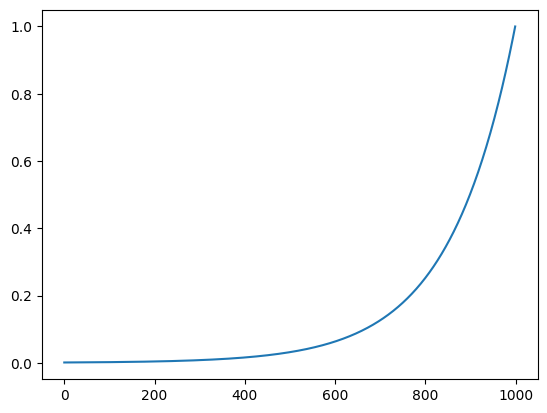

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

lre = torch.linspace(-3,-0,1000)
lr = 10 ** lre
plt.plot(lr)

In [48]:

lri = []
lossi = []

for i in range(1000):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 100==0:
        print(f"Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * lr[i]

    lri.append(lr[i])
    lossi.append(loss.item())

    



Total loss currently is 23.156063079833984
Total loss currently is 19.860105514526367
Total loss currently is 14.739229202270508


Total loss currently is 15.869235038757324
Total loss currently is 9.170475006103516
Total loss currently is 8.597548484802246
Total loss currently is 5.448578357696533
Total loss currently is 7.486325740814209
Total loss currently is 6.4967546463012695
Total loss currently is 8.301974296569824


We choose the learning rate from area where we see the loss is generally low. 
This method might not be mathematically super provable but visually here we actually find area where loss in general is low and gives us good estimation

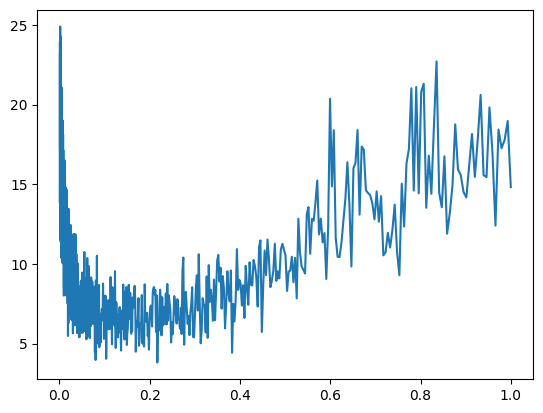

In [49]:
plt.plot(lri,lossi)

# FURTHER TUNING TRAINING TO GET LOWEST LOSS POSSIBLE

In [52]:
EMBEDDING_DIMENSION = 2
CONTEXT_SIZE = 3
TRAINING_SIZE = -1 # -1 means all data
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 30
MAX_ITER = 10000

initialize_global_weights()

Total loss currently is 18.97354507446289
Current learning rate is 0.10000000149011612


Total loss currently is 2.7899205684661865
Current learning rate is 0.09636363387107849
Total loss currently is 2.6949591636657715
Current learning rate is 0.0918181836605072
Total loss currently is 2.6777455806732178
Current learning rate is 0.08727272599935532
Total loss currently is 2.602778434753418
Current learning rate is 0.08272727578878403
Total loss currently is 2.576831340789795
Current learning rate is 0.07818181812763214
Total loss currently is 2.622363567352295
Current learning rate is 0.07363636046648026
Total loss currently is 2.5490822792053223
Current learning rate is 0.06909091025590897
Total loss currently is 2.548710823059082
Current learning rate is 0.06454545259475708
Total loss currently is 2.513432741165161
Current learning rate is 0.05999999865889549
Total loss currently is 2.499136209487915
Current learning rate is 0.055454544723033905
Total loss currently is 2.490770101547241
Current learning rate is 0.050909094512462616
Total loss currently is 2.517597913742

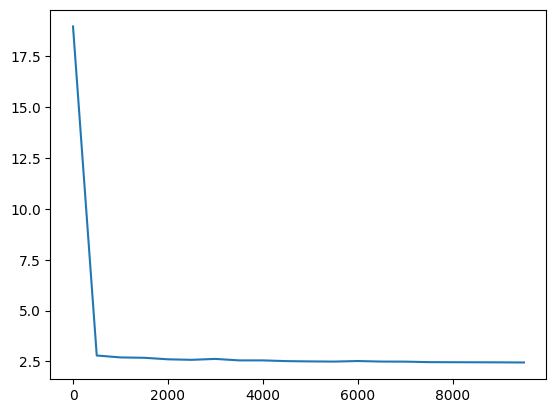

In [29]:
import torch.nn.functional as F


lre = torch.linspace(0,-3,1000) 
lr = 10 ** lre

lossi = []
iter = []


for i in range(MAX_ITER):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(32,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    learning_rate_idx = min(int(i / 10000 * 99), 99)
    learning_rate = lr[learning_rate_idx]

    if i % 500==0:
        # Calculate total loss
        total_h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
        total_logits = total_h @ W2 + B2
        total_loss = F.cross_entropy(total_logits, Y)


        print(f"Total loss currently is {total_loss}")
        print(f"Current learning rate is {learning_rate}")
        
        iter.append(i)
        lossi.append(total_loss.item())

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * learning_rate 



plt.plot(iter,lossi)

## MANUAL FINE TUNING WITH SMALL LEARNING RATE

Total loss currently is 2.4422922134399414
Current learning rate is 0.005
Total loss currently is 2.437227249145508
Current learning rate is 0.005
Total loss currently is 2.4332664012908936
Current learning rate is 0.005
Total loss currently is 2.4362316131591797
Current learning rate is 0.005
Total loss currently is 2.4335739612579346
Current learning rate is 0.005
Total loss currently is 2.4334449768066406
Current learning rate is 0.005
Total loss currently is 2.4333252906799316
Current learning rate is 0.005
Total loss currently is 2.4348127841949463
Current learning rate is 0.005
Total loss currently is 2.4317309856414795
Current learning rate is 0.005
Total loss currently is 2.433026075363159
Current learning rate is 0.005
Total loss currently is 2.4322309494018555
Current learning rate is 0.005
Total loss currently is 2.434750556945801
Current learning rate is 0.005
Total loss currently is 2.432537317276001
Current learning rate is 0.005
Total loss currently is 2.432403087615967


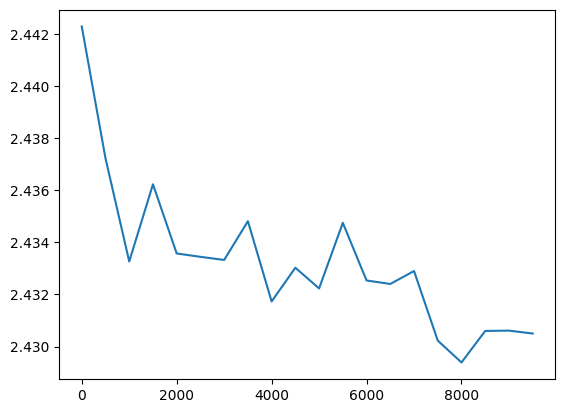

In [30]:
import torch.nn.functional as F


MAX_ITER = 10000


lossi = []
iter = []


learning_rates = torch.linspace(0.1,0.01,100)


for i in range(MAX_ITER):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(32,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    learning_rate = 0.005
    
    if i % 500==0:
        # Calculate total loss
        total_h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
        total_logits = total_h @ W2 + B2
        total_loss = F.cross_entropy(total_logits, Y)

        print(f"Total loss currently is {total_loss}")
        print(f"Current learning rate is {learning_rate}")
        
        iter.append(i)
        lossi.append(total_loss.item())

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * learning_rate 



plt.plot(iter,lossi)

# MAKE TRAINING MORE REPEATABLE

In [31]:
EMBEDDING_DIMENSION=4
CONTEXT_SIZE=3
HIDDEN_LAYER_SIZE=300

In [32]:


def initialize_global_weights():
    global g, C, W1, B1, W2, B2, params
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(27,EMBEDDING_DIMENSION,generator=g) 
    W1 = torch.randn(EMBEDDING_DIMENSION*CONTEXT_SIZE,HIDDEN_LAYER_SIZE,generator=g)
    B1 = torch.randn(HIDDEN_LAYER_SIZE,generator=g) # Add to every neuron bias
    W2 = torch.randn(HIDDEN_LAYER_SIZE,27,generator=g)
    B2 = torch.randn(27) # Add to every neuron bias

    params = [C,W1,B1,W2,B2]
    param_count = sum([p.nelement()  for p in params])

    print(f"Total parameters currently in NN {param_count}")


    for p in params:
        p.requires_grad=True

# Make all parameters to have gradient 


def train(X,Y, iterations, learning_rate, batch_size):
    for i in range(iterations):
        minibatch = torch.randint(0,X.shape[0],(batch_size,))
        h = (C[X[minibatch]].view(-1, CONTEXT_SIZE * EMBEDDING_DIMENSION) @ W1 + B1).tanh()
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y)

        print(f"Total loss currently is {loss}")

        for param in params:
            param.grad=None

        loss.backward()

        for param in params: 
            param.data -= param.grad * 0.1



initialize_global_weights()






Total parameters currently in NN 12135


# TRAIN/DEV/TEST SET

In [33]:
import random
random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr,Ytr = generate_training_data(names[:n1])
Xdv,Ydv = generate_training_data(names[n1:n2])
Xts,Yts = generate_training_data(names[n2:])
